<a href="https://colab.research.google.com/github/borbert/Data-Analysis/blob/master/M4_Proj_(Group_14)_Enron_Dataset_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enron Network Analysis
## Group 14 - Oscar, Skylar, and Bob


In [ ]:
!pip install python-magic
!pip install datetime
!pip install pytz
!pip install scipy
!pip install magic

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pytz
from datetime import datetime
import time
import logging
import subprocess

# Format the current date and time as a string
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Specify drive directory
drivedirectory = "/content/drive/Shareddrives/COSC545-Proj4Enron/"

# Create a log file name that includes the timestamp
notebooklogfile = f'{drivedirectory}logging/notebook-{timestamp}.log'

# Set the timezone, e.g., to 'EST'
os.environ['TZ'] = 'EST'
# Make sure the time library is aware of the new environment setting
time.tzset()

# Create a custom logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)  # Set the desired level

# Add a file handler to log messages to a file
file_handler = logging.FileHandler(notebooklogfile)

# Set the logging level for the file handler
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Prevent the custom logger from propagating messages to the root logger
logger.propagate = False

logger.info(f"Initializing: {notebooklogfile}")

In [ ]:
import pandas as pd
import os
import re
import magic  # Import the magic library

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=['sender', 'recipient', 'weight'])
# Specify the directory to traverse
directory = drivedirectory + "/maildir"


# Function to extract email pairs from a text file
def extract_email_pairs(filename):
    sender = None
    recipients = []
    unique_pairs = set()  # Use a set to track unique pairs
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith("From: "):
                sender = re.search(r'[\w\./=-]+@[\w\.-]+\.\w+|/o=[\w]+/ou=[\w]+/cn=recipients/cn=notesaddr/cn=[\w-]+@[\w\.]+', line)
                if sender:
                    sender = sender.group(0)
            elif line.startswith("To: ") or line.startswith("Cc: ") or line.startswith("Bcc: "):
                emails = re.findall(r'[\w\./=-]+@[\w\.-]+\.\w+|/o=[\w]+/ou=[\w]+/cn=recipients/cn=notesaddr/cn=[\w-]+@[\w\.]+', line)
                recipients.extend(emails)
            elif line.startswith("Cc: ") or line.startswith("Cc: ") or line.startswith("Bcc: "):
                emails = re.findall(r'[\w\./=-]+@[\w\.-]+\.\w+|/o=[\w]+/ou=[\w]+/cn=recipients/cn=notesaddr/cn=[\w-]+@[\w\.]+', line)
                recipients.extend(emails)
            elif line.startswith("Bcc: ") or line.startswith("Cc: ") or line.startswith("Bcc: "):
                emails = re.findall(r'[\w\./=-]+@[\w\.-]+\.\w+|/o=[\w]+/ou=[\w]+/cn=recipients/cn=notesaddr/cn=[\w-]+@[\w\.]+', line)
                recipients.extend(emails)
            elif line.startswith("X-From:"):
                break  # Assuming you want to stop processing at "X-From:"; adjust if needed

    # Create pairs of sender and each recipient, checking for duplicates
    pairs = []
    for recipient in recipients:
        pair = (sender, recipient)
        if pair not in unique_pairs:
            unique_pairs.add(pair)
            pairs.append(pair)

    log_entry = f"Sender: {sender}, Recipients: {', '.join(recipients)}"
    return pairs, log_entry

# Function to flush log messages
def flush_log_messages():
    for handler in logging.getLogger().handlers:
        handler.flush()

# Read through Enron emails and define sender, recipient, and weight.

In [ ]:
import pandas as pd
import os
import magic
import logging
from datetime import datetime

# Assuming the setup for logger, extract_email_pairs function, and other necessary components are defined above

# Initialize DataFrame
df = pd.DataFrame(columns=['sender', 'recipient', 'weight'])

# Specify FILELIMIT
FILELIMIT = 600000
# Initialize the magic library
mime = magic.Magic(mime=True)
# Initialize a counter for the number of files processed
file_count = 0
# Traverse the directory hierarchy
for root, _, files in os.walk(directory):
    for filename in files:
        if file_count >= FILELIMIT:  # Check if 100 files have been processed
            break  # Exit the loop if 100 files have been processed
        file_path = os.path.join(root, filename)
        # Check file type using magic number
        file_type = mime.from_file(file_path)
        if file_type.startswith('text/'):
            try:
                # Process text file using the new extract_email_pairs function
                pairs, log_entry = extract_email_pairs(file_path)
                logger.info(f"File #: {file_count}, processing emails in:{file_path}: {log_entry}")

                # Prepare a list to collect new rows
                new_rows = []
                for sender, recipient in pairs:
                    if sender and recipient:  # Ensure both sender and recipient are not None
                        # Check if the sender-recipient pair already exists
                        mask = (df['sender'] == sender) & (df['recipient'] == recipient)
                        if df[mask].empty:
                            # If not exists, prepare to add a new row
                            new_rows.append({'sender': sender, 'recipient': recipient, 'weight': 1})
                        else:
                            # If exists, increment the weight
                            df.loc[mask, 'weight'] += 1

                # Concatenate new rows to the DataFrame if any
                if new_rows:
                    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

                file_count += 1  # Increment the file counter
            except Exception as e:  # It's better to catch specific exceptions
                print(f"Error processing text file: {filename}, Error: {e}")

        if file_count >= FILELIMIT:  # Check again if 100 files have been processed
            break  # Break out of the outer loop as well

# Assuming flush_log_messages function is defined elsewhere
flush_log_messages()

# Write the DataFrame to a CSV file
curr_timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
outputdir = "/content"
csv_output = f'enron-sender-recipient-weights-{curr_timestamp}.csv'
filtered_csv_output = f'filtered-enron-sender-recipient-weights-{curr_timestamp}.csv'

LOWERLIMIT = 250
filtered_df = df[df['weight'] >= LOWERLIMIT]

df.to_csv(os.path.join(outputdir, csv_output), index=False)
filtered_df.to_csv(os.path.join(outputdir, filtered_csv_output), index=False)
# Save to drive directory
df.to_csv(os.path.join(drivedirectory, csv_output), index=False)
filtered_df.to_csv(os.path.join(drivedirectory, filtered_csv_output), index=False)

In [ ]:
print(df.describe())
df.sort_values(by='weight', ascending=False).head(30)

       sender recipient weight
count       0         0      0
unique      0         0      0
top       NaN       NaN    NaN
freq      NaN       NaN    NaN


,sender,recipient,weight


In [ ]:
# Find duplicate rows
duplicates = df.duplicated(keep=False)

# Display duplicate rows
print(df[duplicates])

Empty DataFrame
Columns: [sender, recipient, weight]
Index: []


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the 'weight' column
df['weight'].hist(bins=100, edgecolor='black')

plt.title('Distribution of Enron Email Sender->Recipient Weights')
plt.xlabel('weight')
plt.ylabel('frequency')

# Show the plot
plt.show()

In [ ]:
# Generate a sequence of indices for the x-axis
x = range(len(df))

# Plot weight against its index
plt.scatter(x, df['weight'], edgecolor='black')

plt.title('Distribution of Weights')
plt.xlabel('Index')
plt.ylabel('Weight')

# Highlighting the mean
plt.axhline(df['weight'].mean(), color='red', linestyle='--', label='Mean Weight')

plt.legend()

# Show the plot
plt.show()

In [ ]:
LOWERLIMIT=250
# Filter the DataFrame to include only weights >= LOWERLIMIT
filtered_df = df[df['weight'] >= LOWERLIMIT]

# Plot histogram of the 'weight' column after filtering
plt.hist(filtered_df['weight'], bins=50, edgecolor='black')

plt.title('Distribution of Enron Email Sender->Recipient Weights (>= LOWERLIMIT)')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# Show the plot
plt.show()

#### Additional ESDA

In [ ]:
import os, warnings
import pandas as pd # did not want to re-run the extraction loop above
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.io as pio
pyo.init_notebook_mode(connected=True)
pio.renderers.default = 'colab'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppress only deprecation and future warnings - they are annoying
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


In [ ]:
initial_groups = pd.read_csv(drivedirectory+'enron-sender-recipient-weights-03-22_07-43.csv')

In [ ]:
FILTEREDLIMIT=250
FILTERED125LIMIT=50
FILTERED50LIMIT=50
FILTERED30LIMIT=30
FILTERED20LIMIT=20
FILTERED10LIMIT=10
filtered = initial_groups[initial_groups['weight']>=FILTEREDLIMIT]
filtered125 = initial_groups[initial_groups['weight']>=FILTERED125LIMIT]
filtered50 = initial_groups[initial_groups['weight']>=FILTERED50LIMIT]
filtered30 = initial_groups[initial_groups['weight']>=FILTERED30LIMIT]
filtered20 = initial_groups[initial_groups['weight']>=FILTERED20LIMIT]
filtered10 = initial_groups[initial_groups['weight']>=FILTERED10LIMIT]

# Compare Top 15 Senders to Known Key Figures
The top 3 figures in the Enron scandal are not even in the top 15 senders. Using charts to visualize this helps us understand that sometimes we need to look for different patterns outside of the amount of emails sent.

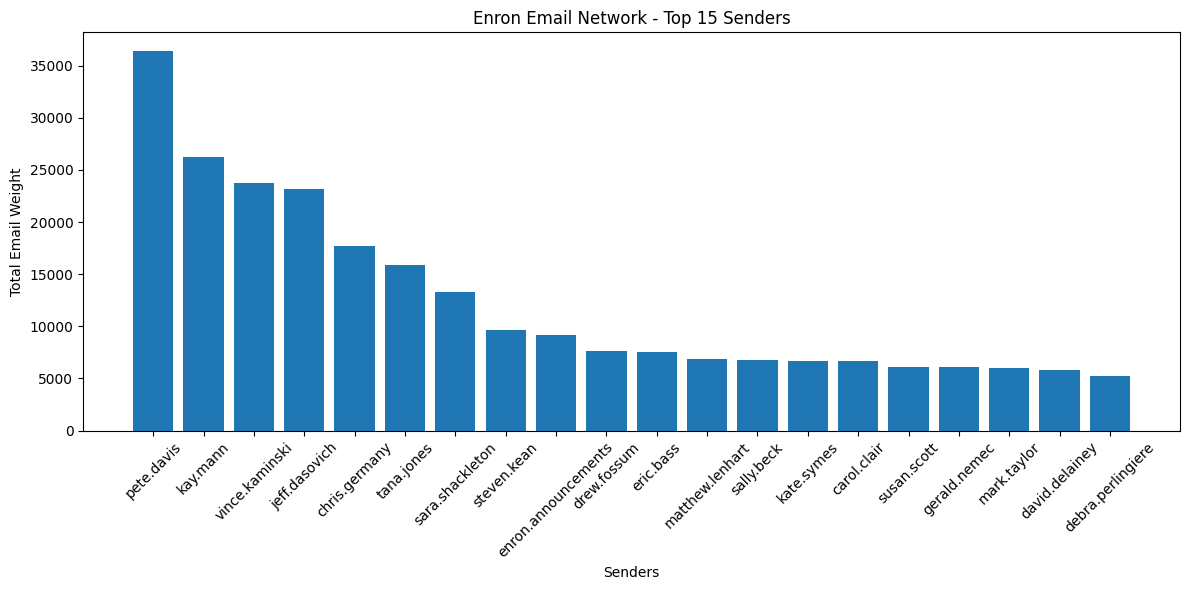

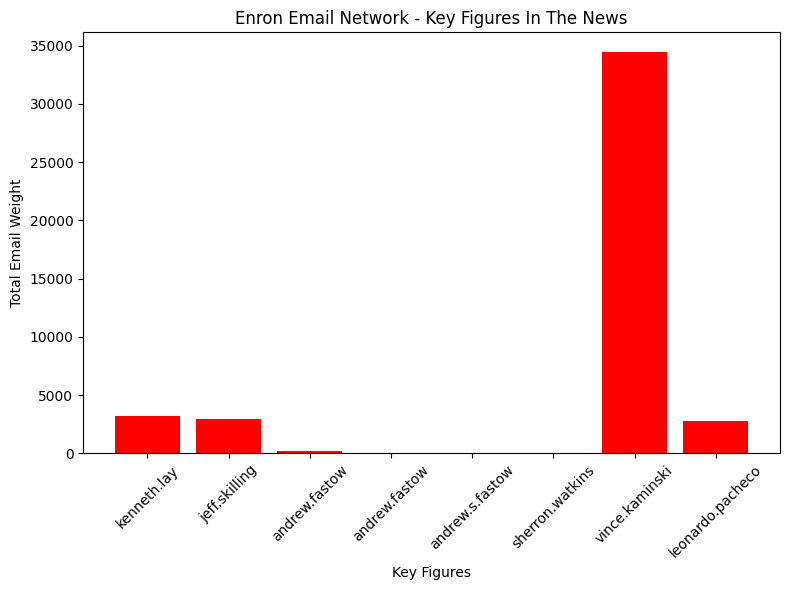

In [ ]:
import matplotlib.pyplot as plt

# Define a list of key figures in the Enron fraud case
key_figures = [
    'kenneth.lay@enron.com',
    'jeff.skilling@enron.com',
    'andrew.fastow@enron.com', 'andrew.fastow@ljminvestments.com', 'andrew.s.fastow@enron.com',
    'sherron.watkins@enron.com',
    'vince.kaminski@enron.com',
    'leonardo.pacheco@enron.com',
    ]

# Create dictionaries to store the weights for each sender and key figure
sender_weights = {}
key_figure_weights = {figure: 0 for figure in key_figures}

# Calculate the total weight for each sender and key figure
for _, row in initial_groups.iterrows():
    sender_weights[row['sender']] = sender_weights.get(row['sender'], 0) + row['weight']
    if row['sender'] in key_figures:
        key_figure_weights[row['sender']] += row['weight']
    if row['recipient'] in key_figures:
        key_figure_weights[row['recipient']] += row['weight']

# Sort the sender weights dictionary by values in descending order
sorted_sender_weights = sorted(sender_weights.items(), key=lambda x: x[1], reverse=True)

# Get the top 15 senders with the highest weights
top_senders = [sender for sender, _ in sorted_sender_weights[:20]]

# Create a bar plot for the top 15 senders
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(range(len(top_senders)), [sender_weights[sender] for sender in top_senders])
ax1.set_xlabel('Senders')
ax1.set_ylabel('Total Email Weight')
ax1.set_title('Enron Email Network - Top 15 Senders')
ax1.set_xticks(range(len(top_senders)))
ax1.set_xticklabels([sender.split('@')[0] for sender in top_senders], rotation=45)
plt.tight_layout()

# Create a bar plot for the key figures involved in the scandal
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.bar(key_figure_weights.keys(), key_figure_weights.values(), color='red')
ax2.set_xlabel('Key Figures')
ax2.set_ylabel('Total Email Weight')
ax2.set_title('Enron Email Network - Key Figures In The News')
ax2.set_xticklabels([figure.split('@')[0] for figure in key_figures], rotation=45)
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
## define a dataframe of key figures as the sender or recipient
key_figures_filtered=initial_groups.copy()
key_figures_filtered['key_sender'] = key_figures_filtered['sender'].apply(lambda x: 1 if any([email in x for email in key_figures]) else 0)
key_figures_filtered['key_recipient'] = key_figures_filtered['recipient'].apply(lambda x: 1 if any([email in x for email in key_figures]) else 0)
key_figures_filtered = key_figures_filtered.loc[(key_figures_filtered['key_recipient'] == 1) | (key_figures_filtered['key_sender'] == 1)]
print(f"Key figures represent {len(key_figures_filtered)}, out of total {len(initial_groups)}")
key_figures_filtered.columns

Key figures represent 2808, out of total 133727


Index(['sender', 'recipient', 'weight', 'key_sender', 'key_recipient'], dtype='object')

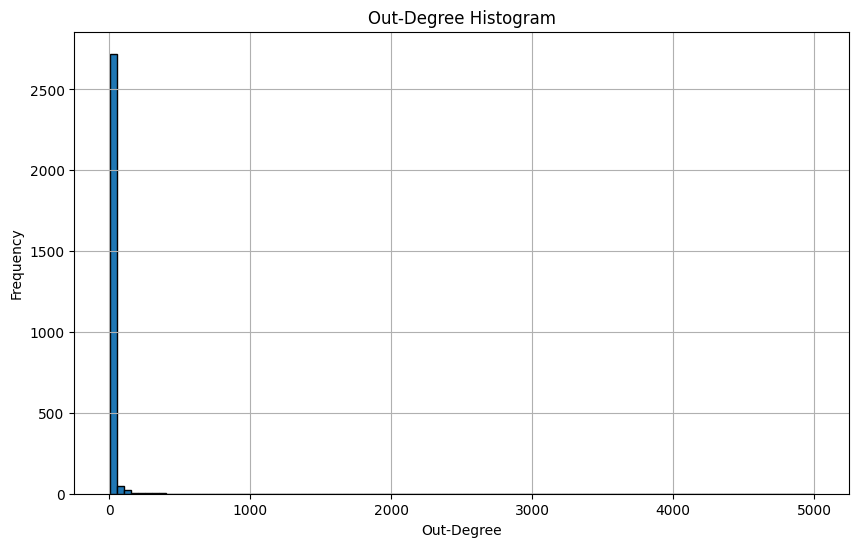

In [ ]:
# Out-Degree Histogram similiar graphs in Using EgocentricNetworks to Understand Communication
# import networkx as nx

# G = nx.DiGraph()

# # Add nodes and edges to the graph
# for _, row in initial_groups.iterrows():
#     G.add_edge(row['sender'], row['recipient'], weight=row['weight'])

# # Calculate the out-degree histogram
# out_degree_hist = nx.degree_histogram(G)

# Plot it
plt.figure(figsize=(10, 6))
key_figures_filtered['weight'].hist(bins=100, edgecolor='black')
# plt.hist(list(range(len(out_degree_hist))), bins=len(out_degree_hist), weights=out_degree_hist)
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.title('Out-Degree Histogram')

plt.show()

# Top Communication Pairs
When sifting through this large dataset, we were able to identify communication pairs which outlines the total weight or messages sent between the 2 people. This allows us to have key insights, like who may be communicating the most between each other. Ex: Pete Davis has the highest communication, but it is himself.

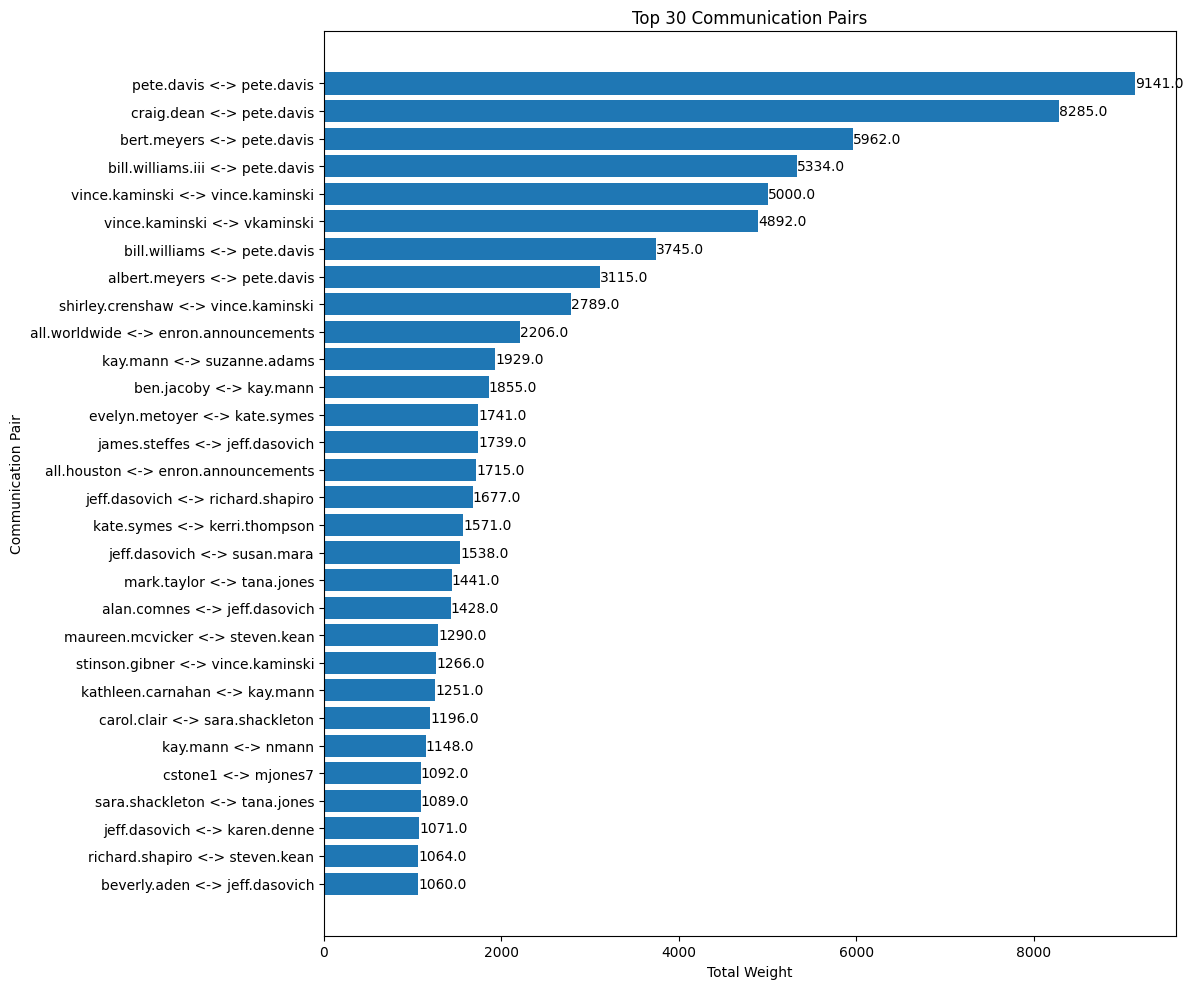

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new DataFrame with 'person1', 'person2', and 'weight' columns
df_pairs = initial_groups[['sender', 'recipient', 'weight']].copy()

# Rename 'sender' and 'recipient' columns to 'person1' and 'person2'
df_pairs.columns = ['person1', 'person2', 'weight']

# Swap 'person1' and 'person2' where 'person1' is greater than 'person2'
mask = df_pairs['person1'] > df_pairs['person2']
df_pairs.loc[mask, ['person1', 'person2']] = df_pairs.loc[mask, ['person2', 'person1']].values

# Group by 'person1' and 'person2' and sum the weights
communication_pairs = df_pairs.groupby(['person1', 'person2'], as_index=False).agg({'weight': 'sum'})

# Sort the communication pairs by total weight in descending order
communication_pairs = communication_pairs.sort_values('weight', ascending=False)

# Get the top 20 communication pairs
top_pairs = communication_pairs.head(30)

# Create a new DataFrame with 'pair' and 'weight' columns
df_plot = pd.DataFrame({'pair': [], 'weight': []})

# Iterate over the top pairs and create a new DataFrame for plotting
for _, row in top_pairs.iterrows():
    person1 = row['person1'].split('@')[0]
    person2 = row['person2'].split('@')[0]
    pair = f"{person1} <-> {person2}"
    weight = row['weight']
    df_plot = df_plot.append({'pair': pair, 'weight': weight}, ignore_index=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(df_plot['pair'], df_plot['weight'])

# Set the chart title and labels
ax.set_title('Top 30 Communication Pairs')
ax.set_xlabel('Total Weight')
ax.set_ylabel('Communication Pair')

# Invert the y-axis to show the pairs in descending order
ax.invert_yaxis()

# Display the weight values next to each bar
for i, v in enumerate(df_plot['weight']):
    ax.text(v + 0.1, i, str(v), color='black', va='center')

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

In [ ]:
key_figures_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2808 entries, 659 to 133695
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sender         2808 non-null   object
 1   recipient      2808 non-null   object
 2   weight         2808 non-null   int64 
 3   key_sender     2808 non-null   int64 
 4   key_recipient  2808 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 131.6+ KB


## Identifying Communication Pairs Among Key Individuals
We did some outside research when analyzing the dataset and discovered some key individuals related to the Enron scandal. When analyzing the dataset in its entirety, the guilty individuals were shadowed by the rest of the employees when analyzing emails. We decided to pick out a few names and look at how they compared to the rest of the company. This helps highlight the difficulty of identifying individuals who might be guilty and how important it is to make the appropriate conclusions.

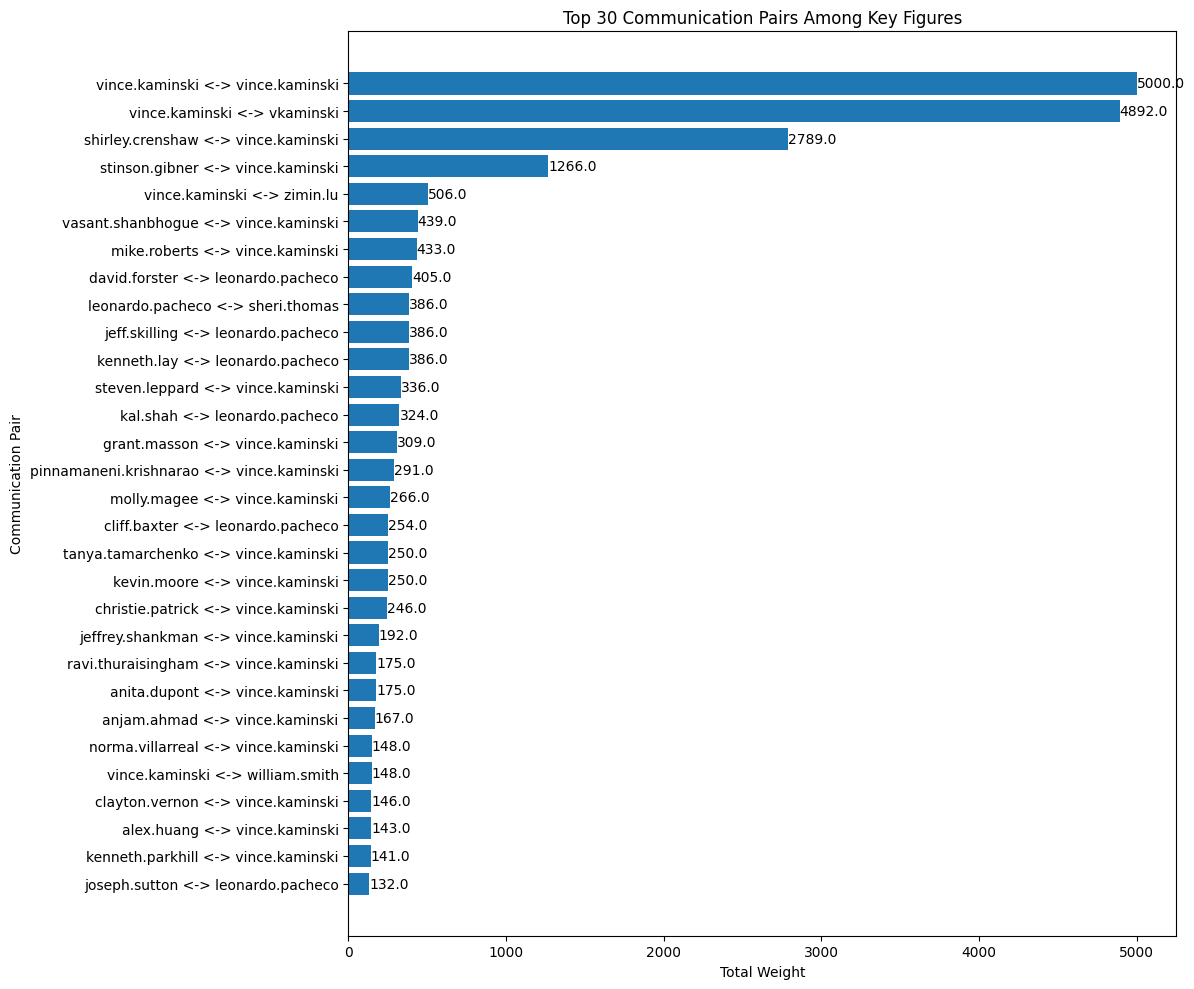

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new DataFrame with 'person1', 'person2', and 'weight' columns
df_pairs = key_figures_filtered[['sender', 'recipient', 'weight']].copy()

# Rename 'sender' and 'recipient' columns to 'person1' and 'person2'
df_pairs.columns = ['person1', 'person2', 'weight']

# Swap 'person1' and 'person2' where 'person1' is greater than 'person2'
mask = df_pairs['person1'] > df_pairs['person2']
df_pairs.loc[mask, ['person1', 'person2']] = df_pairs.loc[mask, ['person2', 'person1']].values

# Group by 'person1' and 'person2' and sum the weights
communication_pairs = df_pairs.groupby(['person1', 'person2'], as_index=False).agg({'weight': 'sum'})

# Sort the communication pairs by total weight in descending order
communication_pairs = communication_pairs.sort_values('weight', ascending=False)

# Get the top 20 communication pairs
top_pairs = communication_pairs.head(30)

# Create a new DataFrame with 'pair' and 'weight' columns
df_plot = pd.DataFrame({'pair': [], 'weight': []})

# Iterate over the top pairs and create a new DataFrame for plotting
for _, row in top_pairs.iterrows():
    person1 = row['person1'].split('@')[0]
    person2 = row['person2'].split('@')[0]
    pair = f"{person1} <-> {person2}"
    weight = row['weight']
    df_plot = df_plot.append({'pair': pair, 'weight': weight}, ignore_index=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(df_plot['pair'], df_plot['weight'])

# Set the chart title and labels
ax.set_title('Top 30 Communication Pairs Among Key Figures')
ax.set_xlabel('Total Weight')
ax.set_ylabel('Communication Pair')

# Invert the y-axis to show the pairs in descending order
ax.invert_yaxis()

# Display the weight values next to each bar
for i, v in enumerate(df_plot['weight']):
    ax.text(v + 0.1, i, str(v), color='black', va='center')

# Adjust the layout and display the chart
plt.tight_layout()
plt.show()

# Distributions of Enron Sender -> Recipient Weights After Filter
These graphs outline the distribution of the amount of messages each sender sent. The more messages sent the higher said person will end up in the distribution.

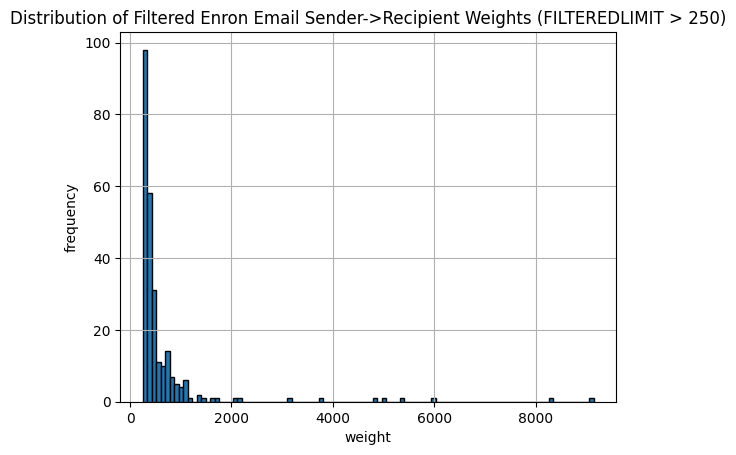

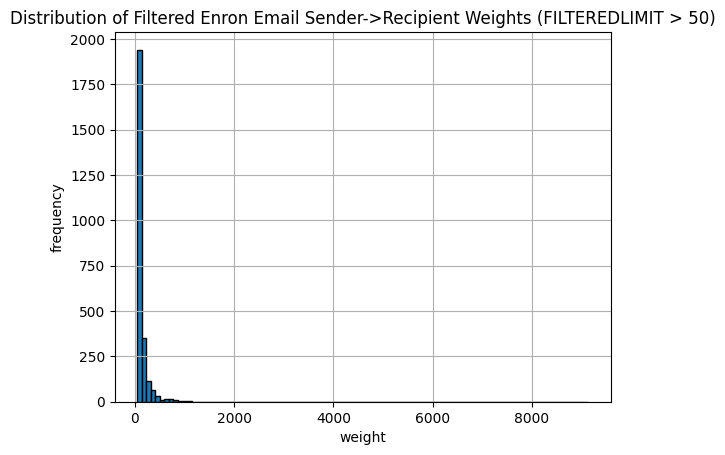

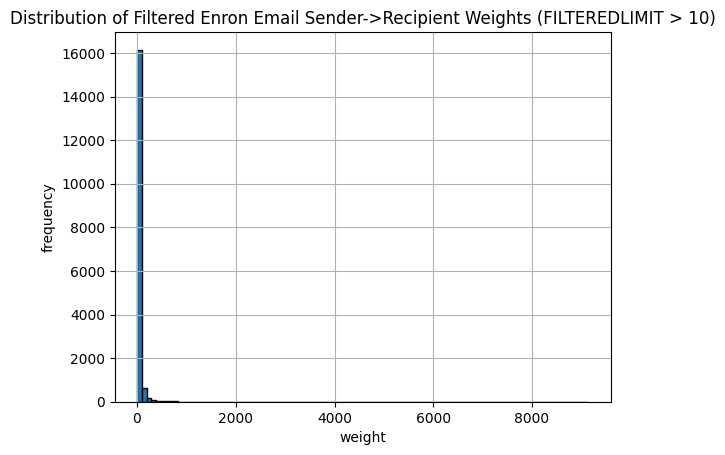

In [ ]:
# Plot histogram of the 'weight' column
filtered['weight'].hist(bins=100, edgecolor='black')

plt.title(f'Distribution of Filtered Enron Email Sender->Recipient Weights (FILTEREDLIMIT > {FILTEREDLIMIT})')
plt.xlabel('weight')
plt.ylabel('frequency')

# Show the plot
plt.show()

# Plot histogram of the 'weight' column
filtered50['weight'].hist(bins=100, edgecolor='black')

plt.title(f'Distribution of Filtered Enron Email Sender->Recipient Weights (FILTEREDLIMIT > {FILTERED50LIMIT})')
plt.xlabel('weight')
plt.ylabel('frequency')

# Show the plot
plt.show()

# Plot histogram of the 'weight' column
filtered10['weight'].hist(bins=100, edgecolor='black')

plt.title(f'Distribution of Filtered Enron Email Sender->Recipient Weights (FILTEREDLIMIT > {FILTERED10LIMIT})')
plt.xlabel('weight')
plt.ylabel('frequency')

# Show the plot
plt.show()

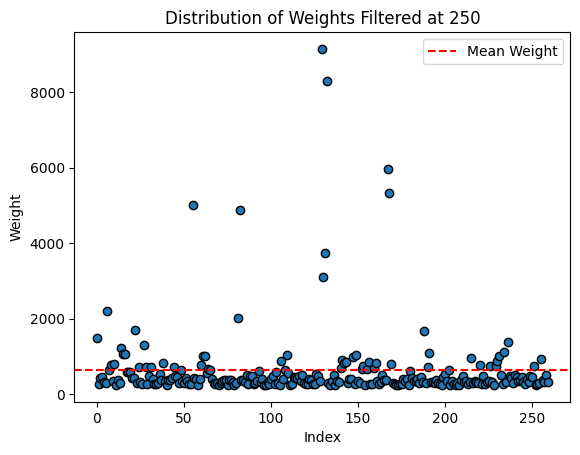

In [ ]:
# Generate a sequence of indices for the x-axis
x = range(len(filtered))

# Plot weight against its index
plt.scatter(x, filtered['weight'], edgecolor='black')

plt.title(f'Distribution of Weights Filtered at {FILTEREDLIMIT}')
plt.xlabel('Index')
plt.ylabel('Weight')

# Highlighting the mean
plt.axhline(filtered['weight'].mean(), color='red', linestyle='--', label='Mean Weight')

plt.legend()

# Show the plot
plt.show()

In [ ]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 61 to 118575
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sender     260 non-null    object
 1   recipient  260 non-null    object
 2   weight     260 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.1+ KB


# Weight Comparison
By visualizing the weights of communication between sender-recipient pairs, we can identify key individuals, detect communication patterns, spot anomalies, understand group dynamics, and perform comparative analysis.

In [ ]:
mean_weight = filtered['weight'].mean()

# Plotly express version allows interactivity
fig = px.scatter(
    filtered,
    x = 'recipient',
    y = 'weight',
    color = 'sender',
    size = 'weight',
    hover_data={"recipient":True,"sender":True,"weight":True,},
)

fig.update_layout(
    width=1200,
    height=1000
)
fig.update_layout(template="plotly_white", )
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(title_text="Weights versus Individuals in Group Pairings")

fig.show()

# write out to the drive (as .html file) for further use, i.e. screenshots, etc.
pyo.plot(fig, filename=drivedirectory+'/graphs/'+"Weights versus Individuals in Group Pairings.html")

'/content/drive/Shareddrives/COSC545-Proj4Enron//graphs/Weights versus Individuals in Group Pairings.html'

In [ ]:
# how many folks emailed themselves

filtered['self'] = filtered.apply(lambda x: 1 if x['sender'] == x['recipient'] else 0, axis=1)

less_self_emails = filtered[filtered['self'] == 0]
print(f"Filtered data without self emails, rows left over {len(less_self_emails)}")

Filtered data without self emails, rows left over 251


In [ ]:
new_mean_weight = less_self_emails['weight'].mean()

# Plotly express allows interactivity of visuals
fig = px.scatter(
    less_self_emails,
    x = 'recipient',
    y = 'weight',
    color = 'sender',
    size = 'weight',
    hover_data={"recipient":True,"sender":True,"weight":True,},
)

fig.update_layout(
    width=1200,
    height=1000
)
fig.update_layout(template="plotly_white")
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(title_text="Weights versus Individuals in Group Pairings W/O Self Emails")

fig.show()

# write out to the drive (as .html file) for further use, i.e. screenshots, etc.
pyo.plot(fig, filename=drivedirectory+'/graphs/'+"Weights versus Individuals in Group Pairings W-O Self Emails.html")

'/content/drive/Shareddrives/COSC545-Proj4Enron//graphs/Weights versus Individuals in Group Pairings W-O Self Emails.html'

In [ ]:
# how many emails are from outside enron?? not quite working yet
def not_enron(email_addr: str)-> bool:
  if 'enron' in email_addr:
    return False
  else:
    return True

# if either the sender or the recipient are from outside of enron
less_self_emails['outside_sender'] = less_self_emails.apply(lambda x: 1 if not_enron(x['sender']) else 0, axis = 1)
less_self_emails['outside_recipient'] = less_self_emails.apply(lambda x: 1 if not_enron(x['recipient']) else 0, axis = 1)
outside_emails = less_self_emails[(less_self_emails['outside_sender']==1)|(less_self_emails['outside_recipient']==1)]
# less_self_emails.head(10)
print(f"The number of email sender-recipients outside enron.com {len(outside_emails)}")
# outside_emails.head(10)

The number of email sender-recipients outside enron.com 45


In [ ]:
# how many were mass emails

# list to hold mass email senders - can be easily adjusted as we find more
mass_comm = [
    'announcements',
    'chairman'
]

less_self_emails['mass_email'] = less_self_emails['sender'].apply(lambda x: 1 if any([word in x for word in mass_comm])else 0)
less_mass_emails = less_self_emails[(less_self_emails['mass_email']==0)&((less_self_emails['outside_sender']==0) & (less_self_emails['outside_recipient']==0))]
# less_mass_emails.info()

In [ ]:
# Enron to Enron employee emails
fig = px.scatter(
    less_mass_emails,
    x = 'recipient',
    y = 'weight',
    color = 'sender',
    size = 'weight',
    hover_data={"recipient":True,"sender":True,"weight":True,},
)

fig.update_layout(
    width=1200,
    height=1000
)
fig.update_layout(template="plotly_white")
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(title_text="Weights versus Individuals in Enron to Enron emails")

fig.show()

# write out to the drive (as .html file) for further use, i.e. screenshots, etc.
pyo.plot(fig, filename=drivedirectory+'/graphs/'+"Weights versus Individuals in Enron to Enron emails.html")

'/content/drive/Shareddrives/COSC545-Proj4Enron//graphs/Weights versus Individuals in Enron to Enron emails.html'

In [ ]:
# Enron to outside emails
fig = px.scatter(
    outside_emails,
    x = 'recipient',
    y = 'weight',
    color = 'sender',
    size = 'weight',
    hover_data={"recipient":True,"sender":True,"weight":True,},
)

fig.update_layout(
    width=1200,
    height=1000
)
fig.update_layout(template="plotly_white")
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(title_text="Weights versus Individuals for Outside Emails")

fig.show()

# write out to the drive (as .html file) for further use, i.e. screenshots, etc.
pyo.plot(fig, filename=drivedirectory+'/graphs/'+"Weights versus Individuals for Outside Emails.html")

'/content/drive/Shareddrives/COSC545-Proj4Enron//graphs/Weights versus Individuals for Outside Emails.html'

# Create Gephi-formatted files (.csv's) from Pandas Dataframes

In [ ]:
gephidir=drivedirectory+'gephi'
print(f"gephi output directory: {gephidir}")

# Assuming each value in dataframes_output is a DataFrame with a 'sender' column
dataframes_output = {
    'original_unfiltered': initial_groups,
    'filtered_to_250limited': filtered,
    'filtered_to_125limited': filtered125,
    'filtered_to_50limited': filtered50,
    'filtered_to_30limited': filtered30,
    'filtered_to_20limited': filtered20,
    'filtered_to_10limited': filtered10,
    'less_self': less_mass_emails,
    'key_figures': key_figures_filtered
}

# Loop through each DataFrame in the dictionary
for key, df in dataframes_output.items():
    # Create 'Label' column by removing the "@" and the email domain from the 'sender' column
    df['Label'] = df['sender'].apply(lambda x: x.split('@')[0] if '@' in x else x)

    # insert 'Label' column after 'weight' column specifically
    if 'weight' in df.columns:
        # Remove 'Label' column and store it
        label_col = df.pop('Label')
        # Insert 'Label' column after 'weight'
        df.insert(df.columns.get_loc('weight') + 1, 'Label', label_col)
    # If for some reason there is no 'weight' column, 'Label' is already added at the end

    # Print the key (DataFrame name) and the first few rows of the updated DataFrame
    print(f"DataFrame: {key}")
    print(df.head(3))  # Adjust the number inside head() as needed
    print(f"The dataframe contains {len(df)} rows")
    print("\n")  # Add a newline for better readability between DataFrames

In [ ]:
# Loop through the dictionary and write each DataFrame to a CSV file
for df_name, df in dataframes_output.items():
    file_path = f'{gephidir}/{df_name}.csv'  # Construct file path based on DataFrame name
    # Check if the file already exists
    df.rename(columns={'sender':'Source', 'recipient':'Target', 'weight':'Weight'},inplace=True)
    print(df.columns)
    if not os.path.exists(file_path):
        try:
            df.to_csv(file_path, index=False)
            print(f'Successfully wrote {file_path}')
        except Exception as e:
            print(f'Error writing {file_path}: {e}')
    else:
        print(f'File {file_path} already exists. Skipping write.')

Index(['Source', 'Target', 'Weight', 'Label'], dtype='object')
File /content/drive/Shareddrives/COSC545-Proj4Enron/gephi/original_unfiltered.csv already exists. Skipping write.
Index(['Source', 'Target', 'Weight', 'Label', 'self'], dtype='object')
File /content/drive/Shareddrives/COSC545-Proj4Enron/gephi/filtered_to_250limited.csv already exists. Skipping write.
Index(['Source', 'Target', 'Weight', 'Label'], dtype='object')
File /content/drive/Shareddrives/COSC545-Proj4Enron/gephi/filtered_to_125limited.csv already exists. Skipping write.
Index(['Source', 'Target', 'Weight', 'Label'], dtype='object')
File /content/drive/Shareddrives/COSC545-Proj4Enron/gephi/filtered_to_50limited.csv already exists. Skipping write.
Index(['Source', 'Target', 'Weight', 'Label'], dtype='object')
File /content/drive/Shareddrives/COSC545-Proj4Enron/gephi/filtered_to_30limited.csv already exists. Skipping write.
Index(['Source', 'Target', 'Weight', 'Label'], dtype='object')
File /content/drive/Shareddrives/C

# Reflection


## Obeservation One
There are a few individuals responsible for most of the weight of the communications in the Enron dataset.  This was evident from the original dataset and throughout every slice of the data.  Removing self emails, mass internal communciations, and focusing on some of the key figures in the news showed the same data characteristics. Histograms were heavily left weighted in all of the progressive filters of the data.

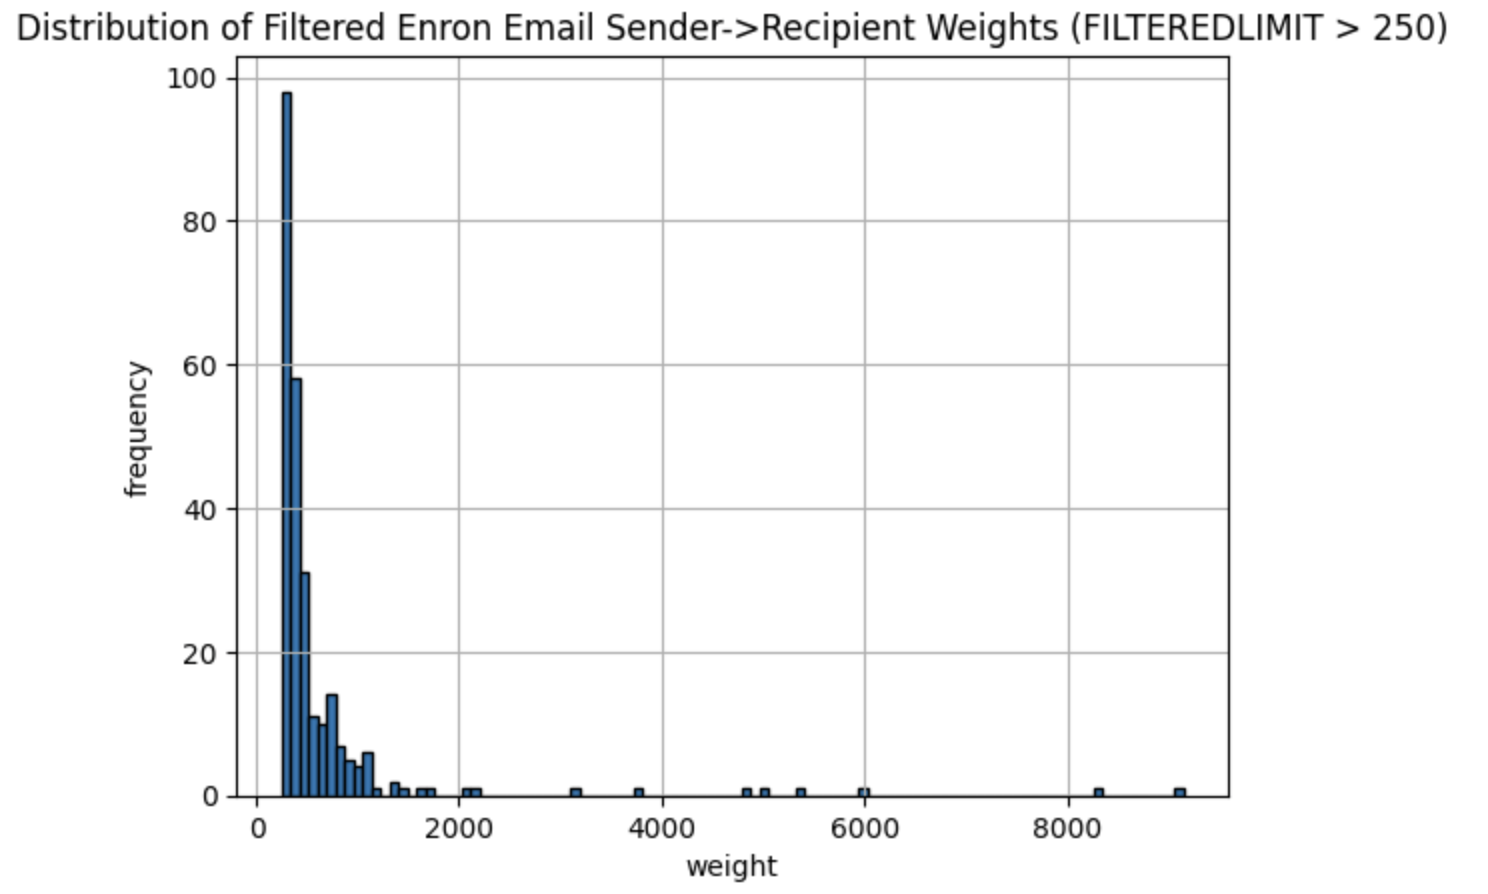

In [13]:
from IPython.display import Image
Image(filename='/content/drive/Shareddrives/COSC545-Proj4Enron/pics/histogram.png',width=700, height=500)

## Obeservation Two
There were several communication pairs where at least one the pair was outside of Enron. The major person contributing to this was Vince Kaminski.  It appears that his outside emails were to his personal AOL account.  At the magnitude at which he appears it is possible he was copying or blind copying himself on every email.  He was also one of the early objectors and employees who spoke out about the accounting irregularities at Enron which explains some of this activity. You can see in the data of external emails what appears to be relatives who also use email as a means of communication.  


## Obeservation Three (Onion Pattern and Technical Support Role)
The dataset filtered to some of the key figures at Enron displayed the "onion" network pattern of the Soylent project when graphed in Gephi.

There is a handful of communicators generating most of the messages. There are slight concentric rings but some messages are strictly out-degree communication. The original graph in Gephi of the key figures showed a pattern similar to a technical support role in the Roles project.  

This could be due to the hierarchical communicatiton within the company.  This shows they are likely a few people acting as "answer people".  There is quite a bit of out-degree where they sending messages to others that may not be sending messages to many other people.    

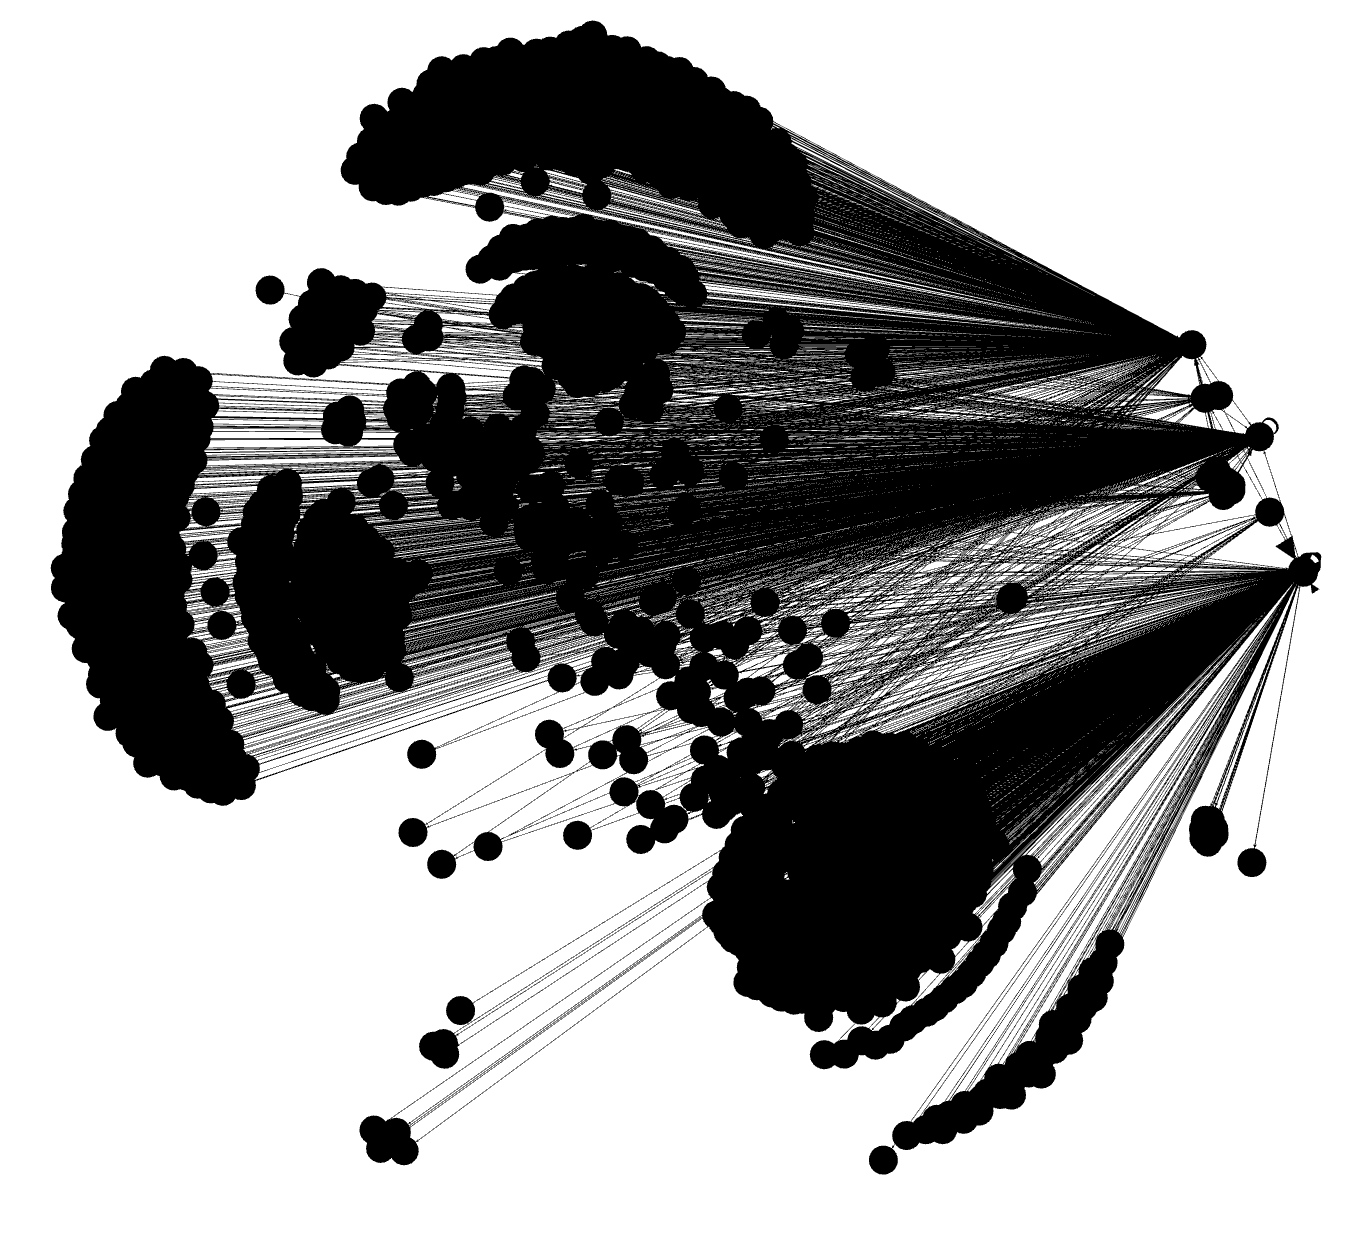

In [9]:
Image(filename='/content/drive/Shareddrives/COSC545-Proj4Enron/pics/onion_graph.png',width=800, height=800)

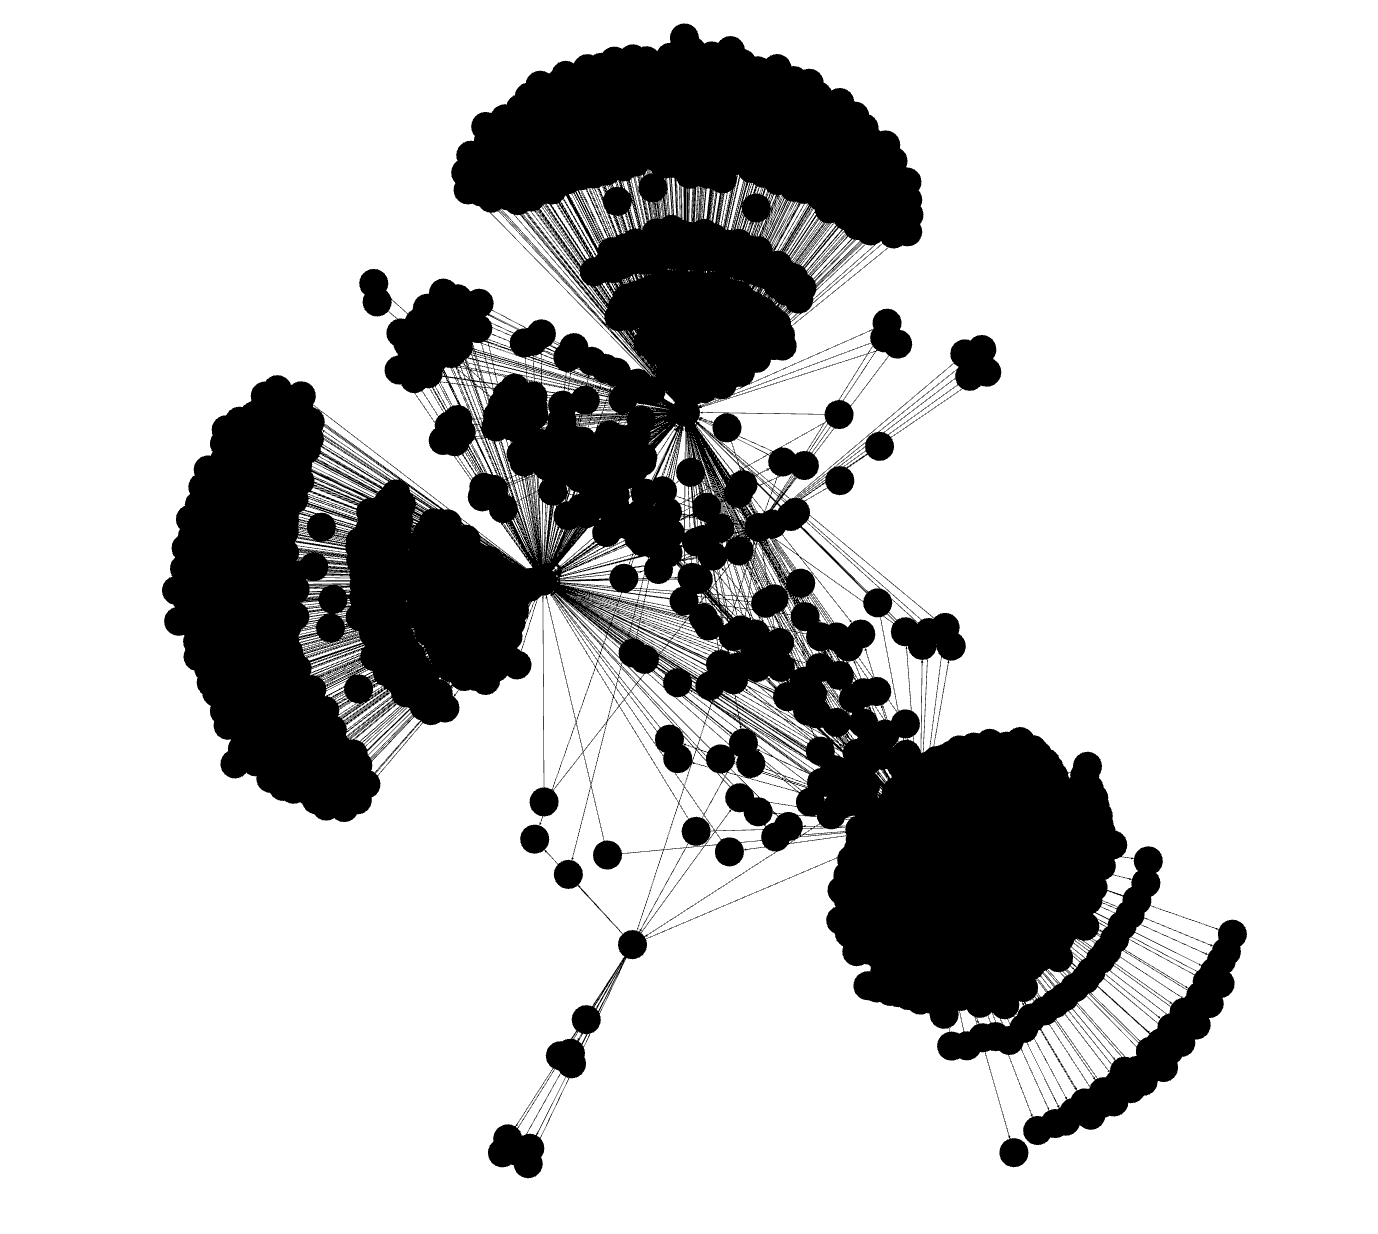

In [11]:
Image(filename='/content/drive/Shareddrives/COSC545-Proj4Enron/pics/roles_graph.png',width=700, height=700)

## Conclusions

Our analysis of the Enron dataset revealed several key insights and patterns within the company. Despite knowing key individuals in the Enron scandal, they were not among the top 15 senders of emails. This shows how important it to look beyond simple metrics like emails in and out to make meaningful connections. We also noticed when creating communication pairs between the employees, the vast amount of emails ended up left-weighted showing the emails were only made by a few groups. This was the case despite filtering the data.

Additionally, we were able perform an analysis showing there were lots of emails being sent to addresses outside of Enron. Vince Kaminski was was among one of the main contributors to said emails, possibly highlighting how he felt about Enron's accounting inconsistencies. When compiling all of the data and inserting into Gephi, it revealed an 'onion' network pattern. This suggests there is a hierarchical communication structure within Enron. Ultimately, these few key findings were interesting and allows us to understand how difficult it is for researchers to make meaningful conclusions from large datasets.